In [ ]:
# Note: Importing segmentation models library may give you generic_utils error on TF2.x
# When the error shows up, click the __init__.py link in the error message and change..
# keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to
# keras.utils.get_custom_objects().update(custom_objects)
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Note: Importing segmentation models library may give you generic_utils error on TF2.x
# When the error shows up, click the __init__.py link in the error message and change..
# keras.utils.generic_utils.get_custom_objects().update(custom_objects)
# to
# keras.utils.get_custom_objects().update(custom_objects)
# Then save the init.py file and restart runtime and run this cell

import segmentation_models as sm
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)
#from keras.utils import normalize
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# import tensorflow
# from tensorflow import keras
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import MeanIoU
from keras.callbacks import Callback

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
from tqdm import tqdm
from google.colab import drive


from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
base_dir = os.getcwd()

assert os.path.exists(drive_dir) # if this fails, something went wrong with mounting GoogleDrive
if os.path.exists(mount_dir) is False:
    os.makedirs(mount_dir)

device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.13.1
2.13.0
Mounted at /content/drive


SystemError: ignored

In [ ]:
import numpy
print(numpy.__version__)

1.23.5


In [ ]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")
from data_augmentation import DataAugmentation

# Parameters to change according to experiment
n_training_subjects = 3
n_classes = 5 #Number of classes for segmentation
training_augmentation = True
num_augmentations = 1
patient_index_training = [1,4,7,11,21]

print("Number of Patients: ", len(patient_index_training))
print("Number of Segmentation Classes: ", n_classes)
print(("Data Augmentation: {}").format(training_augmentation))
print('\n')

image_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/*.nii.gz")
image_names.sort()


mask_names = glob.glob("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/*.nii.gz")
mask_names.sort()


image_names_train, mask_names_train = [], []
for i in range (len(image_names)):
  patient_index = int((image_names[i].split('_'))[-2])
  for x in range (len(patient_index_training)):
    if (patient_index == patient_index_training[x]):
      image_names_train.append(image_names[i])
      mask_names_train.append(mask_names[i])
image_names = image_names_train
mask_names = mask_names_train

image_names_train = image_names[0:n_training_subjects]
mask_names_train = mask_names[0:n_training_subjects]

image_names_validation = image_names[n_training_subjects+1:]
mask_names_validation = mask_names[n_training_subjects+1:]



print(image_names)
print(mask_names)
print('\n')

for image in tqdm(image_names_train, desc = 'Reading in Training MRI Images'):
  print(image)
  img = nib.load(image)
  img_data = img.get_fdata()
  if (image == image_names_train[0]):
    img_stack_train = img_data
  else:
    img_stack_train = np.concatenate((img_stack_train, img_data), axis = 0)


for mask in tqdm(mask_names_train, desc = 'Reading in Training Multi-Class Labelled Masks'):
  print(mask)
  msk = nib.load(mask)
  msk_data = msk.get_fdata()
  if (mask == mask_names_train[0]):
    msk_stack_train = msk_data
  else:
    msk_stack_train = np.concatenate((msk_stack_train, msk_data), axis = 0)
msk_stack_train = msk_stack_train.astype(np.uint8)


for image in tqdm(image_names_validation, desc = 'Reading in Validation MRI Images'):
  print(image)
  img = nib.load(image)
  img_data = img.get_fdata()
  if (image == image_names_validation[0]):
    img_stack_validation = img_data
  else:
    img_stack_validation = np.concatenate((img_stack_validation, img_data), axis = 0)


for mask in tqdm(mask_names_validation, desc = 'Reading in Validation Multi-Class Labelled Masks'):
  print(mask)
  msk = nib.load(mask)
  msk_data = msk.get_fdata()
  if (mask == mask_names_validation[0]):
    msk_stack_validation = msk_data
  else:
    msk_stack_validation = np.concatenate((msk_stack_validation, msk_data), axis = 0)
msk_stack_validation = msk_stack_validation.astype(np.uint8)



print('\n')
print("Max pixel value in training data: ", img_stack_train.max())
print("Labels in the training mask: ", np.unique(msk_stack_train))


if (training_augmentation == True):
  print('\n')
  print('-'*30)
  print('Data Augmentation Starting...')
  print('-'*30)

  img_stack_aug, msk_stack_aug = DataAugmentation(img_stack_train, msk_stack_train, num_augmentations)

  img_stack_aug = np.expand_dims(img_stack_aug, axis=-1)
  msk_stack_aug = np.expand_dims(msk_stack_aug, axis=-1)

  print('Number of Augmentation per Input: ', num_augmentations)
  print('\n')
  print('Shape of Augmented Images: ', img_stack_aug.shape)
  print('Shape of Augmented Masks: ', msk_stack_aug.shape)
  print('\n')

  if True:
      img_stack = np.concatenate((img_stack_train, img_stack_aug), axis=0)
      msk_stack = np.concatenate((msk_stack_train, msk_stack_aug), axis=0)

  print('Shape of Training Image Data: ', img_stack.shape)
  print('Shape of Training Image Masks: ', msk_stack.shape)

  print('-'*30)
  print('Completed Data Augmentation Stage!')
  print('-'*30)
  print('\n')

# Channel = 3
img_stack_train = np.repeat(img_stack_train, 3, axis=3)
img_stack_validation = np.repeat(img_stack_validation, 3, axis=3)

#Split training data
# X_train, X_test, y_train, y_test = train_test_split(img_stack, msk_stack, test_size = 0.2, random_state = 42)

X_train = img_stack_train
X_test = img_stack_validation
y_train = msk_stack_train
y_test = msk_stack_validation

train_masks_cat = to_categorical(msk_stack_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(msk_stack_validation, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print('Training Images Shape: ', X_train.shape)
print('Training Labels Shape: ', y_train.shape)
print('Validation Images Shape: ', X_test.shape)
print('Validation Labels Shape;: ', y_test.shape)

Number of Patients:  5
Number of Segmentation Classes:  5
Data Augmentation: True


['/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_001_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_004_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_007_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_011_0000.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_021_0000.nii.gz']
['/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_001.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_004.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_007.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_011.nii.gz', '/content/drive/MyDrive/Colab Notebooks/nnU

Reading in Training MRI Images:   0%|          | 0/3 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_001_0000.nii.gz


Reading in Training MRI Images:  33%|███▎      | 1/3 [00:02<00:04,  2.17s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_004_0000.nii.gz


Reading in Training MRI Images:  67%|██████▋   | 2/3 [00:05<00:02,  2.56s/it]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_007_0000.nii.gz


Reading in Training Multi-Class Labelled Masks:   0%|          | 0/3 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_001.nii.gz


Reading in Training Multi-Class Labelled Masks:  33%|███▎      | 1/3 [00:00<00:01,  1.59it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_004.nii.gz


Reading in Training Multi-Class Labelled Masks:  67%|██████▋   | 2/3 [00:01<00:00,  1.19it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_007.nii.gz


Reading in Validation MRI Images:   0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/msk_021_0000.nii.gz


Reading in Validation MRI Images: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
Reading in Validation Multi-Class Labelled Masks:   0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/msk_021.nii.gz


Reading in Validation Multi-Class Labelled Masks: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]




Max pixel value in training data:  0.9777405261993408
Labels in the training mask:  [0 1 2 3 4]


------------------------------
Data Augmentation Starting...
------------------------------


100%|██████████| 1656/1656 [00:07<00:00, 230.52it/s]


Number of Augmentation per Input:  1


Shape of Augmented Images:  (1656, 256, 256, 1)
Shape of Augmented Masks:  (1656, 256, 256, 1)


Shape of Training Image Data:  (3312, 256, 256, 1)
Shape of Training Image Masks:  (3312, 256, 256, 1)
------------------------------
Completed Data Augmentation Stage!
------------------------------


Training Images Shape:  (1656, 256, 256, 3)
Training Labels Shape:  (1656, 256, 256, 1)
Validation Images Shape:  (501, 256, 256, 3)
Validation Labels Shape;:  (501, 256, 256, 1)


In [ ]:
# model parameters

def dice_score(y_true, y_pred):
    y_true_f = tensorflow.keras.backend.flatten(y_true)
    y_pred_f = tensorflow.keras.backend.flatten(y_pred)
    intersection = tensorflow.keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1e-5) / (tensorflow.keras.backend.sum(y_true_f) + tensorflow.keras.backend.sum(y_pred_f) + 1e-5)

class DiceScoreCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_x, val_y = self.validation_data
        val_preds = self.model.predict(val_x)
        val_dice = dice_score(val_y, val_preds)
        print(f"Val Dice Score: {val_dice:.4f}")



activation='softmax'

initial_lr = 0.0001
optim = tensorflow.keras.optimizers.Adam(learning_rate=initial_lr)
def lr_schedule(epoch):
    return initial_lr - (0.000001 * epoch)
lr_scheduler = tensorflow.keras.callbacks.LearningRateScheduler(lr_schedule)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss

# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    dice_score
]


# Model
BACKBONE = 'resnet34'
# BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes=n_classes, activation=activation)

preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_processed = preprocess_input(X_train)
X_test_processed = preprocess_input(X_test)

# imagenet pre-trained weights
# Freeze encoder weights
model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes=n_classes, activation=activation, encoder_freeze=True)

# Fine-tune encoder and decoder weights
# model = sm.Unet(BACKBONE, encoder_weights = 'imagenet', classes=n_classes, activation=activation)

save_model_name = '/content/drive/MyDrive/Colab Notebooks/resnet50_backbone_40_epochs_dicefocal_256_5P_24batch_maxF1_pelvis_aug_encoderfreeze_dynamicLR_subjectbasis_best.hdf5'
dice_score_callback = DiceScoreCallback(validation_data=(X_test_processed, y_test_cat))
checkpoint = ModelCheckpoint(save_model_name, monitor='val_f1-score', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.compile(optim, total_loss, metrics=metrics)
# model.compile(optim, dice_loss, metrics=metrics)

print(BACKBONE)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
# Model Training

# Kill runtime after training
AFKRun = True

history=model.fit(X_train_processed,
          y_train_cat,
          batch_size=16,
          epochs=40,
          verbose=1,
          validation_data=(X_test_processed, y_test_cat),
          callbacks=[checkpoint, lr_scheduler, dice_score_callback])

model.save('/content/drive/MyDrive/Colab Notebooks/res34_backbone_20_epochs_dicefocal_256_4P_12batch_maxF1_pelvis_aug_final.keras')

# Performance plots
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



val_acc = history.history['val_dice_score']
plt.plot(epochs, val_acc, 'r', label='Validation Dice Score')
plt.title('Validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()



if AFKRun:
  from google.colab import runtime
  runtime.unassign()

Epoch 1/40


NotImplementedError: ignored

In [ ]:
#Set compile=False as we are not loading it for training, only for prediction.
model_fname = '/content/drive/MyDrive/Colab Notebooks/res34_backbone_20_epochs_dicefocal_256_4P_12batch_maxF1_pelvis_aug_final.keras'
model = load_model(model_fname, compile=False)
BACKBONE = 'resnet50'
pred_name = 'msk_002'

n_classes = 5

print(('Fined-Tuned Model: {}').format((model_fname.split('/'))[-1]))
print('Prediction Scan Stack: ', pred_name)
print('Number of Segmentation Classes: ', n_classes)
print('\n')

img = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTr/{}_0000.nii.gz").format(pred_name))
# img = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTs/{}_0000.nii.gz").format(pred_name))
img_data = img.get_fdata()
X_test = np.repeat(img_data, 3, axis=3)

msk = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/labelsTr/{}.nii.gz").format(pred_name))
# msk = nib.load(("/content/drive/MyDrive/Colab Notebooks/nnUNet_raw/Dataset001_Tibia/imagesTs/{}.nii.gz").format(pred_name))
y_test = msk.get_fdata()

print("Test Images Shape: ", X_test.shape)
print("Test Masks Shape: ", y_test.shape)
print("Test Labels: ", np.unique(y_test))
print('\n')


# Model
# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test_processed = preprocess_input(X_test)
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


# Prediction
y_pred=model.predict(X_test_processed)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_pred_argmax = np.expand_dims(y_pred_argmax, axis = -1)
print('Pred Mask Shape: ', y_pred_argmax.shape)
print("Pred Mask Labels: ", np.unique(y_pred_argmax))
print('\n')

combined_mask = y_pred_argmax.astype(np.int32)
# combined_img = nib.Nifti1Image(combined_mask, msk.affine)
combined_img = nib.Nifti1Image(combined_mask, affine=np.eye(4), dtype=np.int32)
nib.save(combined_img, ("/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/{}_pred.nii.gz").format(pred_name), dtype = np.uint8)
print('Exported Prediction Segmentation: ', ("/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/{}_pred.nii.gz").format(pred_name))
print('\n')

# from keras.metrics import MeanIoU
# Calculate Mean IoU
# IOU_keras = MeanIoU(num_classes=n_classes)
# IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
# values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
# class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
# class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
# class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
# class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[0,4]+ values[1,4]+ values[2,3])

def dice_coefficient(true_array, pred_array):
    true_array = np.asarray(true_array).astype(bool)
    pred_array = np.asarray(pred_array).astype(bool)

    intersection = np.logical_and(true_array, pred_array)
    dice = 2.0 * intersection.sum() / (true_array.sum() + pred_array.sum())
    return round(dice, 2)

def volume_error(y_true, y_pred):
    # mm3
    Voxel_Volume = 2.63671875

    N_true = np.count_nonzero(y_true)
    N_pred = np.count_nonzero(y_pred)

    volume_error = np.abs(N_true - N_pred) * Voxel_Volume

    return round(volume_error * 0.001, 2)


tibia_seg_data_pred = np.where(y_pred_argmax != 1, 0, 1)
femur_seg_data_pred = np.where(y_pred_argmax != 2, 0, 1)
fibula_seg_data_pred = np.where(y_pred_argmax != 3, 0, 1)
pelvis_seg_data_pred = np.where(y_pred_argmax != 4, 0, 1)

tibia_seg_data_gt = np.where(y_test != 1, 0, 1)
femur_seg_data_gt = np.where(y_test != 2, 0, 1)
fibula_seg_data_gt = np.where(y_test != 3, 0, 1)
pelvis_seg_data_gt = np.where(y_test != 4, 0, 1)

dice_score_tibia = dice_coefficient(tibia_seg_data_gt, tibia_seg_data_pred)
dice_score_femur = dice_coefficient(femur_seg_data_gt, femur_seg_data_pred)
dice_score_fibula = dice_coefficient(fibula_seg_data_gt, fibula_seg_data_pred)
dice_score_pelvis = dice_coefficient(pelvis_seg_data_gt, pelvis_seg_data_pred)

TIBIA_VError = volume_error(tibia_seg_data_gt, tibia_seg_data_pred)
FEMUR_VError = volume_error(femur_seg_data_gt, femur_seg_data_pred)
FIBULA_VError = volume_error(fibula_seg_data_gt, fibula_seg_data_pred)
PELVIS_VError = volume_error(pelvis_seg_data_gt, pelvis_seg_data_pred)

print('Dice Score - Tibia:', dice_score_tibia)
print('Dice Score - Femur:', dice_score_femur)
print('Dice Score - Fibula:', dice_score_fibula)
print('Dice Score - Pelvis:', dice_score_pelvis)
print('\n')

print('VError - Tibia:', TIBIA_VError)
print('VError - Femur:', FEMUR_VError)
print('VError - Fibula:', FIBULA_VError)
print('VError - Pelvis:', PELVIS_VError)

Fined-Tuned Model: res34_backbone_20_epochs_dicefocal_256_4P_12batch_maxF1_pelvis_aug_final.keras
Prediction Scan Stack:  msk_002
Number of Segmentation Classes:  5


Test Images Shape:  (499, 256, 256, 3)
Test Masks Shape:  (499, 256, 256, 1)
Test Labels:  [0. 1. 2. 3. 4.]


16/16 [==============================] - 21s 418ms/step
Pred Mask Shape:  (499, 256, 256, 1)
Pred Mask Labels:  [0 1 2 3 4]


Exported Prediction Segmentation:  /content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/msk_002_pred.nii.gz


Dice Score - Tibia: 0.86
Dice Score - Femur: 0.88
Dice Score - Fibula: 0.59
Dice Score - Pelvis: 0.82


VError - Tibia: 14646.97
VError - Femur: 76.46
VError - Fibula: 1139.06
VError - Pelvis: 31282.03


In [ ]:
%pip install SimpleITK
import SimpleITK as sitk
import numpy as np
from skimage.measure import marching_cubes
%pip install trimesh
import trimesh

predfname = 'msk_002'
model_used = 'resnet34'

def Export3DStructure(segmentation_data, predfname, class_msk, model_used):
    # Generate a surface mesh using marching cubes
    vertices, faces, normals, _ = marching_cubes(segmentation_data, level=0)

    # Create a Trimesh object
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)


    # Save the mesh as a PLY file
    ply_path = ('/content/drive/MyDrive/Colab Notebooks/nnUNet_results/Dataset001_Tibia/predTs/Transfer Learning/{}_{}_{}.ply').format(predfname, class_msk, model_used)
    mesh.export(ply_path)

segmentation_data_all = y_pred_argmax
segmentation_data_all = segmentation_data_all[:,:,:,0]

tibia_seg_data = np.where(segmentation_data_all != 1, 0, 1)
femur_seg_data = np.where(segmentation_data_all != 2, 0, 2)
fibula_seg_data = np.where(segmentation_data_all != 3, 0, 3)
pelvis_seg_data = np.where(segmentation_data_all != 4, 0, 4)

segmentation_data = [segmentation_data_all, tibia_seg_data, femur_seg_data, fibula_seg_data, pelvis_seg_data]
class_msk = ['ALL', 'TIBIA', 'FEMUR', 'FIBULA']

colors = [(255, 0, 0, 255),    # Red
          (0, 255, 0, 255),    # Green
          (0, 0, 255, 255),    # Blue
          (255, 255, 0, 255)]  # Yellow

for i in range (len(segmentation_data)):
  Export3DStructure(segmentation_data[i], predfname, class_msk[i], model_used)

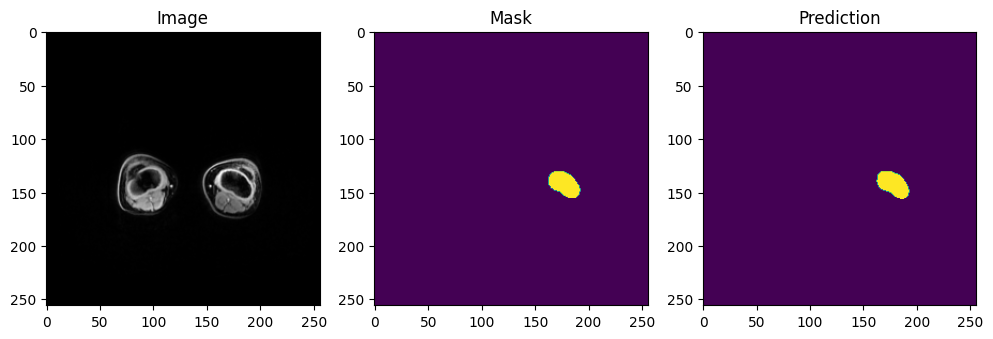

In [ ]:
import random
img_number = random.randint(0, len(X_test_processed)-1)
img = X_test_processed[img_number, :, :, 0]
mask = y_test[img_number]
prediction = y_pred_argmax[img_number]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img, cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask[:,:,0])
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction)
plt.show()